In [222]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.ensemble import RandomForestRegressor


In [223]:


df = pd.read_csv("london_weather_data_1979_to_2023.csv")
df2 = pd.read_csv("london_energy.csv")

# Convert temperature from 0.1°C to °C
df['TX'] = df['TX'] / 10
df['TN'] = df['TN'] / 10
df['TG'] = df['TG'] / 10

In [224]:
avg_kwh = df2.groupby('Date')['KWH'].mean()
avg_kwh = pd.DataFrame({'date':avg_kwh.index.tolist(), 'consumption':avg_kwh.values.tolist()})
avg_kwh['date'] = pd.to_datetime(avg_kwh['date'])

In [225]:
# Step 2: Convert the weather data 'DATE' column to datetime
# Keep DATE column as datetime (do not convert to string)
df['date'] = pd.to_datetime(df['DATE'], format='%Y%m%d')

In [226]:
merged_df = pd.merge(avg_kwh, df.drop(columns=['DATE']), on='date', how='inner')

print(merged_df.isna().any()[lambda x: x])
print(merged_df.info())
print(merged_df.head())
print(f"Number of null values: {merged_df.isnull().sum().sum()}")

columns_to_fill = ['HU', 'CC']
merged_df[columns_to_fill] = merged_df[columns_to_fill].ffill()

print(merged_df.info())
df = merged_df

HU    True
CC    True
dtype: bool
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         829 non-null    datetime64[ns]
 1   consumption  829 non-null    float64       
 2   TX           829 non-null    float64       
 3   Q_TX         829 non-null    int64         
 4   TN           829 non-null    float64       
 5   Q_TN         829 non-null    int64         
 6   TG           829 non-null    float64       
 7   Q_TG         829 non-null    int64         
 8   SS           829 non-null    float64       
 9   Q_SS         829 non-null    int64         
 10  SD           829 non-null    float64       
 11  Q_SD         829 non-null    int64         
 12  RR           829 non-null    float64       
 13  Q_RR         829 non-null    int64         
 14  QQ           829 non-null    float64       
 15  Q_QQ         829 non-nu

In [227]:
threshold_temp = 25  # °C
window = 3

#Identify hot days
df["is_hot"] = df["TX"] >= threshold_temp

#Find consecutive hot days
df["consecutive_hot_days"] = df["is_hot"].rolling(window=window, min_periods=window).sum()

#Define heatwave criteria: 3+ days with max temp ≥ 25°C in London
#In the UK, a heatwave is declared when the daily temperature of a certain location meets or exceeds the heatwave temperature threshold for at least three days.
# Check if the current day is part of a qualifying streak(3)

df["is_heatwave"] = False

# Mark days as heatwave if they are hot and there's a streak
for i in range(len(df)):
    if df.iloc[i]["is_hot"]: #Check specific day forwards and backwards to see if part of heatwave
        start_check = max(0, i - window + 1)
        end_check = min(len(df), i + window)
        
        for start_pos in range(start_check, i + 1):
            end_pos = start_pos + window
            if end_pos <= len(df):
                streak = df.iloc[start_pos:end_pos]["is_hot"].sum()
                if streak >= window and start_pos <= i < end_pos:
                    df.iloc[i, df.columns.get_loc("is_heatwave")] = True
                    break

# Create heatwave groups
df['heatwave_group'] = 0
current_group = 0

for i in range(len(df)):
    if df.iloc[i]['is_heatwave']:
        if i == 0 or not df.iloc[i-1]['is_heatwave']:
            # start of new heatwave
            current_group += 1
        df.iloc[i, df.columns.get_loc('heatwave_group')] = current_group

# Clean up tempcolumns
columns_to_drop = []
if 'is_hot' in df.columns:
    columns_to_drop.append('is_hot')
if 'hot_day_group' in df.columns:
    columns_to_drop.append('hot_day_group')
if columns_to_drop:
    df.drop(columns=columns_to_drop, inplace=True)

# Display results
print("Columns in dataframe:", df.columns.tolist())
print("\nLast 5 days of dataset:")
# print(df[["DATE", "TX", "is_heatwave"]].tail())
print()

# Check for heatwaves
summer_heatwaves = df[df['is_heatwave'] == True]
print(f"Total number of heatwave days: {len(summer_heatwaves)}")
print(f"Number of separate heatwave events: {df['heatwave_group'].max()}")
print("\nFirst few heatwave records:")
print(summer_heatwaves[["date", "TX", "is_heatwave", "heatwave_group"]].head(10))

# heatwave events summary
print("\n" + "="*50)
print("HEATWAVE EVENTS SUMMARY")
print("="*50)

heatwave_events = []
for group in range(1, df['heatwave_group'].max() + 1):
    group_data = df[df['heatwave_group'] == group]
    if len(group_data) > 0:
        if 'date' in df.columns:
            start_date = group_data['date'].min()
            end_date = group_data['date'].max()
        # else:
        #     start_date = pd.to_datetime(group_data['DATE'].astype(str).min(), format='%Y%m%d')
        #     end_date = pd.to_datetime(group_data['DATE'].astype(str).max(), format='%Y%m%d')
        
        duration = len(group_data)
        max_temp = group_data['TX'].max()
        avg_temp = group_data['TX'].mean()
        
        heatwave_events.append({
            'Event': group,
            'Start_Date': start_date.strftime('%Y-%m-%d'),
            'End_Date': end_date.strftime('%Y-%m-%d'),
            'Duration_Days': duration,
            'Max_Temp_C': round(max_temp, 1),
            'Avg_Temp_C': round(avg_temp, 1)
        })

# convert to df for display
events_df = pd.DataFrame(heatwave_events)
print(events_df.head(10))

# stats
print(f"\nHEATWAVE STATISTICS:")
print(f"Average heatwave duration: {events_df['Duration_Days'].mean():.1f} days")
print(f"Longest heatwave: {events_df['Duration_Days'].max()} days")
print(f"Shortest heatwave(minimum to be declared): {events_df['Duration_Days'].min()} days")
print(f"Highest temperature during heatwaves: {events_df['Max_Temp_C'].max()}°C")

# specific heatwave example
print(f"\nEX: Heatwave Event #1 details:")
first_heatwave = df[df['heatwave_group'] == 1]
if 'date' in df.columns:
    print(first_heatwave[['date', 'TX', 'is_heatwave']].to_string(index=False))
else:
    print(first_heatwave[['date', 'TX', 'is_heatwave']].to_string(index=False))


Columns in dataframe: ['date', 'consumption', 'TX', 'Q_TX', 'TN', 'Q_TN', 'TG', 'Q_TG', 'SS', 'Q_SS', 'SD', 'Q_SD', 'RR', 'Q_RR', 'QQ', 'Q_QQ', 'PP', 'Q_PP', 'HU', 'Q_HU', 'CC', 'Q_CC', 'consecutive_hot_days', 'is_heatwave', 'heatwave_group']

Last 5 days of dataset:

Total number of heatwave days: 45
Number of separate heatwave events: 9

First few heatwave records:
          date    TX  is_heatwave  heatwave_group
180 2012-05-21  25.7         True               1
181 2012-05-22  27.2         True               1
182 2012-05-23  27.0         True               1
183 2012-05-24  25.9         True               1
184 2012-05-25  25.9         True               1
185 2012-05-26  27.6         True               1
186 2012-05-27  26.3         True               1
242 2012-07-22  27.4         True               2
243 2012-07-23  28.9         True               2
244 2012-07-24  30.2         True               2

HEATWAVE EVENTS SUMMARY
   Event  Start_Date    End_Date  Duration_Days  Max_Te

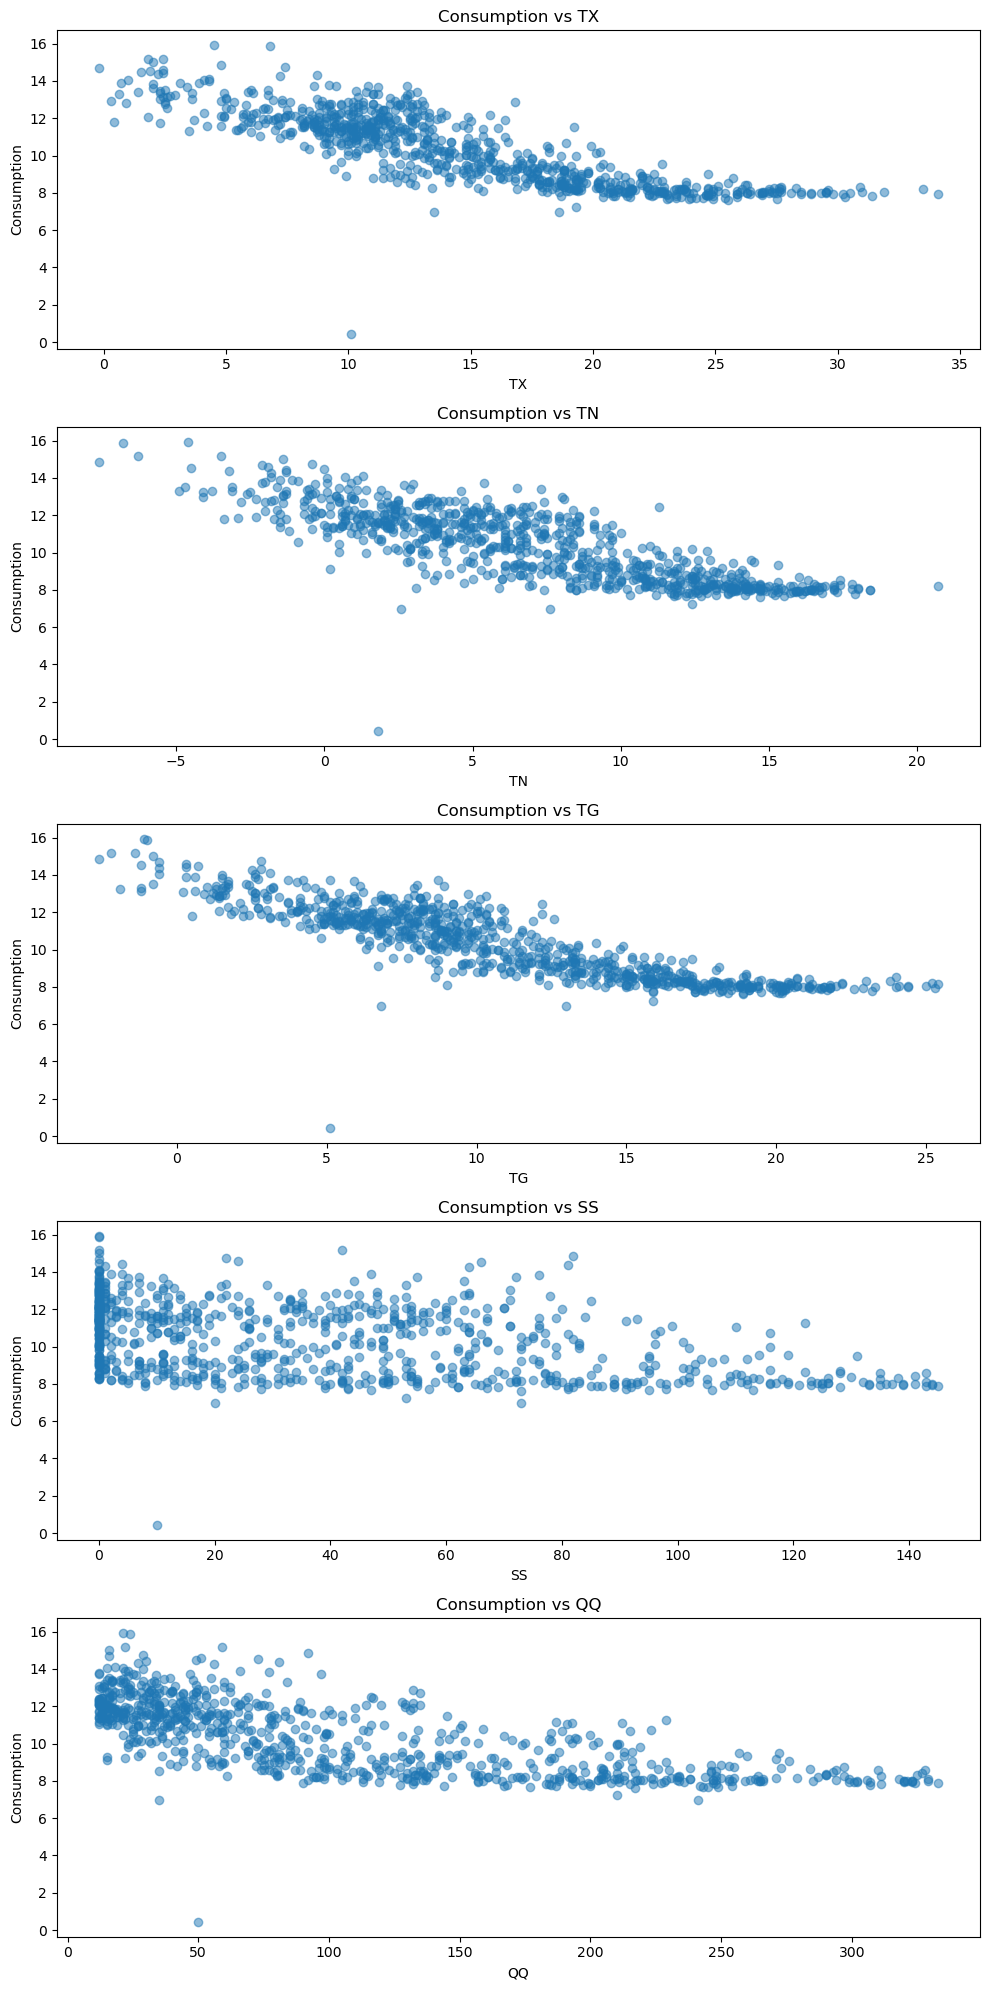

In [228]:

valid_features_to_plot = ['TX', 'TN', 'TG', 'SS', 'QQ']

# DATE: Date in YYYYMMDD format.
# TX: Daily maximum temperature in 0.1°C.
# TN: Daily minimum temperature in 0.1°C.
# TG: Daily mean temperature in 0.1°C.
# SS: Daily sunshine duration in 0.1 hours.
# SD: Daily snow depth in 1 cm.
# RR: Daily precipitation amount in 0.1 mm.
# QQ: Daily global radiation in W/m².
# PP: Daily sea level pressure in 0.1 hPa.
# HU: Daily relative humidity in %.
# CC: Daily cloud cover in oktas.

# Create subplots
fig, axes = plt.subplots(nrows=len(valid_features_to_plot), ncols=1, figsize=(10, 4 * len(valid_features_to_plot)))

for i, feature in enumerate(valid_features_to_plot):
    axes[i].scatter(df[feature], df['consumption'], alpha=0.5)
    axes[i].set_title(f'Consumption vs {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Consumption')

plt.tight_layout()
plt.show()

Coefficients: [-0.22083909  0.01273095 -0.06864659]
Intercept: 13.645434138285044
Mean squared error (MSE): 0.6493199784300688
R² score: 0.8263905394951492


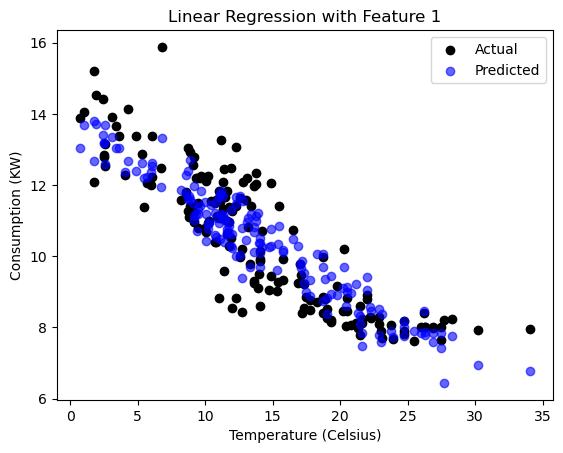

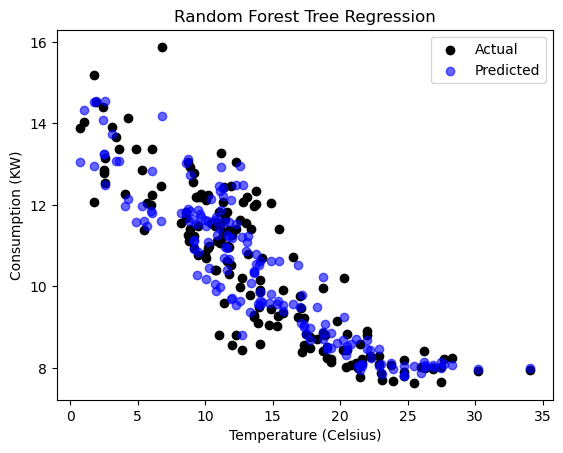

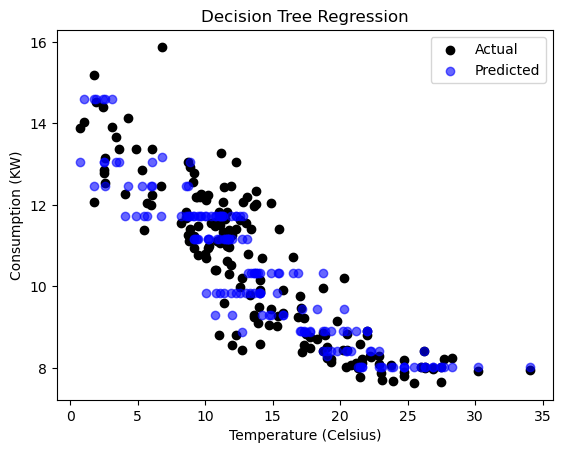

Linear Regression
Mean squared error (MSE): 0.6493199784300688
R² score: 0.8263905394951492
Root Mean Squared Error (RMSE): 0.8058039329949122
Mean Absolute Error (MAE): 0.6269858836560068
Median Absolute Error: 0.540154327300983

Random Forest Regression
Mean squared error (MSE): 0.667169083398248
R² score: 0.8216182029169459
Root Mean Squared Error (RMSE): 0.8168041891409764
Mean Absolute Error (MAE): 0.6073658907477529
Median Absolute Error: 0.45592214090185745

Decision Tree
Mean squared error (MSE): 0.6100849217609821
R² score: 0.8368808635995553
Root Mean Squared Error (RMSE): 0.78107933128523
Mean Absolute Error (MAE): 0.5594035219197304
Median Absolute Error: 0.388705853880543


In [230]:
X = df[['TG','TN','TX']]
y = df['consumption']

X_train,X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,train_size=0.8,random_state=42)
# Initialze regression
model = LinearRegression()
dtr = DecisionTreeRegressor(max_depth=4, random_state=0)
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Linear Regression
model.fit(X_train,y_train)
y_pred_linear = model.predict(X_test)

# Decision Tree Regression
dtr.fit(X_train, y_train)
y_pred_tree = dtr.predict(X_test)

# Random Forest Regression model
rf.fit(X_train, y_train)
y_pred_random_forest = rf.predict(X_test)


print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("Mean squared error (MSE):", mean_squared_error(y_test, y_pred_linear))
print("R² score:", r2_score(y_test, y_pred_linear))


# Linear Regression plot
plt.scatter(X_test.iloc[:, 2], y_test, color='black', label='Actual')
plt.scatter(X_test.iloc[:, 2], y_pred_linear, color='blue', label='Predicted', alpha=0.6)
# plt.plot(X_test, y_pred_linear, color="red", linewidth=2, label="prediction")
plt.xlabel('Temperature (Celsius)')
plt.ylabel('Consumption (KW)')
plt.title('Linear Regression with Feature 1')
plt.legend()
plt.show()

# Random Forest Regression

plt.scatter(X_test.iloc[:, 2], y_test, color='black', label='Actual')
plt.scatter(X_test.iloc[:, 2], y_pred_random_forest, color='blue', label='Predicted', alpha=0.6)
# plt.plot(X_test, y_pred_tree, color="red", linewidth=2, label="prediction")
plt.xlabel('Temperature (Celsius)')
plt.ylabel('Consumption (KW)')
plt.title("Random Forest Tree Regression")
plt.legend()
plt.show()

# Decision Tree plot
plt.scatter(X_test.iloc[:, 2], y_test, color='black', label='Actual')
plt.scatter(X_test.iloc[:, 2], y_pred_tree, color='blue', label='Predicted', alpha=0.6)
# plt.plot(X_test, y_pred_tree, color="red", linewidth=2, label="prediction")
plt.xlabel('Temperature (Celsius)')
plt.ylabel('Consumption (KW)')
plt.title("Decision Tree Regression")
plt.legend()
plt.show()


print("Linear Regression")
print("Mean squared error (MSE):", mean_squared_error(y_test, y_pred_linear))
print("R² score:", r2_score(y_test, y_pred_linear))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_test, y_pred_linear)))
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred_linear))
print("Median Absolute Error:", median_absolute_error(y_test, y_pred_linear))
print()
print("Random Forest Regression")
print("Mean squared error (MSE):", mean_squared_error(y_test, y_pred_random_forest))
print("R² score:", r2_score(y_test, y_pred_random_forest))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_test, y_pred_random_forest)))
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred_random_forest))
print("Median Absolute Error:", median_absolute_error(y_test, y_pred_random_forest))
print()
print("Decision Tree")
print("Mean squared error (MSE):", mean_squared_error(y_test, y_pred_tree))
print("R² score:", r2_score(y_test, y_pred_tree))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_test, y_pred_tree)))
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred_tree))
print("Median Absolute Error:", median_absolute_error(y_test, y_pred_tree))




